In [ ]:
import os
import torch
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.nn as nn
from collections import Counter
from random import choice
from PIL import Image
import torchvision.transforms.functional as TF

import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm.auto import tqdm





# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Define paths to our dataset
train_path = '/content/drive/My Drive/Colab Notebooks/public-data/image/dataset/train'
valid_path = '/content/drive/My Drive/Colab Notebooks/public-data/image/dataset/val'
test_path = '/content/drive/My Drive/Colab Notebooks/public-data/image/dataset/test'

def analyze_dataset(path):
    class_counts = Counter()
    for class_dir in os.listdir(path):
        class_path = os.path.join(path, class_dir)
        if os.path.isdir(class_path):
            count = len(os.listdir(class_path))
            class_counts[class_dir] = count
    return class_counts


transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

train_ds = datasets.ImageFolder(train_path, transform=transform)
test_ds = datasets.ImageFolder(test_path, transform=transform)
valid_ds = datasets.ImageFolder(valid_path, transform=transform)

train_loader = DataLoader(train_ds, batch_size=20, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=20, shuffle=False)
valid_loader = DataLoader(valid_ds, batch_size=20, shuffle=False)




# Define CNN model
class CustomCNN(nn.Module):
    def __init__(self, num_classes):
        super(CustomCNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.fc_layers = nn.Sequential(
            nn.Linear(128 * 28 * 28, 512),
            nn.ReLU(),
            nn.Dropout(0.5),  # Dropout layer for regularization
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.fc_layers(x)
        return x

# Initialize the model
num_classes = len(train_ds.classes)
model = CustomCNN(num_classes)

# Define device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)



# Training loop with early stopping based on validation loss
num_epochs = 20
patience = 3
best_loss = float('inf')  # Initialize best_loss to a very high value
patience_counter = 0      # Initialize patience_counter

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    train_corrects = 0

    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        train_corrects += torch.sum(preds == labels.data)

    train_loss = train_loss / len(train_loader.dataset)
    train_acc = train_corrects.double() / len(train_loader.dataset)
    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}')

    # Validation step
    model.eval()
    valid_loss = 0.0
    with torch.no_grad():
        for images, labels in valid_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            valid_loss += loss.item() * images.size(0)

    valid_loss = valid_loss / len(valid_loader.dataset)

    # Early stopping check based on validation loss
    if valid_loss < best_loss:
        best_loss = valid_loss
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f'Early stopping triggered at epoch {epoch+1}')
            break

    print(f'Epoch {epoch+1}/{num_epochs}, Valid Loss: {valid_loss:.4f}')

# Test the model
model.eval()
test_loss = 0.0
test_corrects = 0
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in tqdm(test_loader, desc="Testing"):
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)

        test_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        test_corrects += torch.sum(preds == labels.data)

        all_preds.extend(preds.view(-1).cpu().numpy())
        all_labels.extend(labels.view(-1).cpu().numpy())

test_loss = test_loss / len(test_loader.dataset)
test_acc = test_corrects.double() / len(test_loader.dataset)
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}')

# Confusion Matrix and Metrics
from sklearn.metrics import classification_report, confusion_matrix

cm = confusion_matrix(all_labels, all_preds)
print("Confusion Matrix:")
print(cm)

print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=[str(i) for i in range(num_classes)]))

# Metrics for each class separately
for i in range(num_classes):
    print(f"\nMetrics for Class {i}:")
    class_indices = [j for j, x in enumerate(all_labels) if x == i]
    class_preds = [all_preds[k] for k in class_indices]
    class_labels = [all_labels[k] for k in class_indices]
    print(classification_report(class_labels, class_preds, labels=[i]))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Epoch 1/20:   0%|          | 0/327 [00:00<?, ?it/s]

Epoch 1/20, Train Loss: 0.5997, Train Acc: 0.7720
Epoch 1/20, Valid Loss: 0.2569


Epoch 2/20:   0%|          | 0/327 [00:00<?, ?it/s]

Epoch 2/20, Train Loss: 0.2327, Train Acc: 0.9209
Epoch 2/20, Valid Loss: 0.1112


Epoch 3/20:   0%|          | 0/327 [00:00<?, ?it/s]

Epoch 3/20, Train Loss: 0.1211, Train Acc: 0.9625
Epoch 3/20, Valid Loss: 0.0674


Epoch 4/20:   0%|          | 0/327 [00:00<?, ?it/s]

Epoch 4/20, Train Loss: 0.0855, Train Acc: 0.9748
Epoch 4/20, Valid Loss: 0.0660


Epoch 5/20:   0%|          | 0/327 [00:00<?, ?it/s]

Epoch 5/20, Train Loss: 0.0592, Train Acc: 0.9859
Epoch 5/20, Valid Loss: 0.0419


Epoch 6/20:   0%|          | 0/327 [00:00<?, ?it/s]

Epoch 6/20, Train Loss: 0.0396, Train Acc: 0.9879
Epoch 6/20, Valid Loss: 0.0725


Epoch 7/20:   0%|          | 0/327 [00:00<?, ?it/s]

Epoch 7/20, Train Loss: 0.0413, Train Acc: 0.9887
Epoch 7/20, Valid Loss: 0.1592


Epoch 8/20:   0%|          | 0/327 [00:00<?, ?it/s]

Epoch 8/20, Train Loss: 0.0470, Train Acc: 0.9853
Early stopping triggered at epoch 8


Testing:   0%|          | 0/41 [00:00<?, ?it/s]

Test Loss: 0.0796, Test Accuracy: 0.9804
Confusion Matrix:
[[202   2   0   0]
 [  4 194   3   3]
 [  0   1 203   0]
 [  3   0   0 201]]

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       204
           1       0.98      0.95      0.97       204
           2       0.99      1.00      0.99       204
           3       0.99      0.99      0.99       204

    accuracy                           0.98       816
   macro avg       0.98      0.98      0.98       816
weighted avg       0.98      0.98      0.98       816


Metrics for Class 0:
              precision    recall  f1-score   support

           0       1.00      0.99      1.00       204

   micro avg       1.00      0.99      1.00       204
   macro avg       1.00      0.99      1.00       204
weighted avg       1.00      0.99      1.00       204


Metrics for Class 1:
              precision    recall  f1-score   support

           1       1.00      0.95

# **Confusion Matrix for Test Result**

Confusion Matrix:
[[202   2   0   0]
 [  4 194   3   3]
 [  0   1 203   0]
 [  3   0   0 201]]


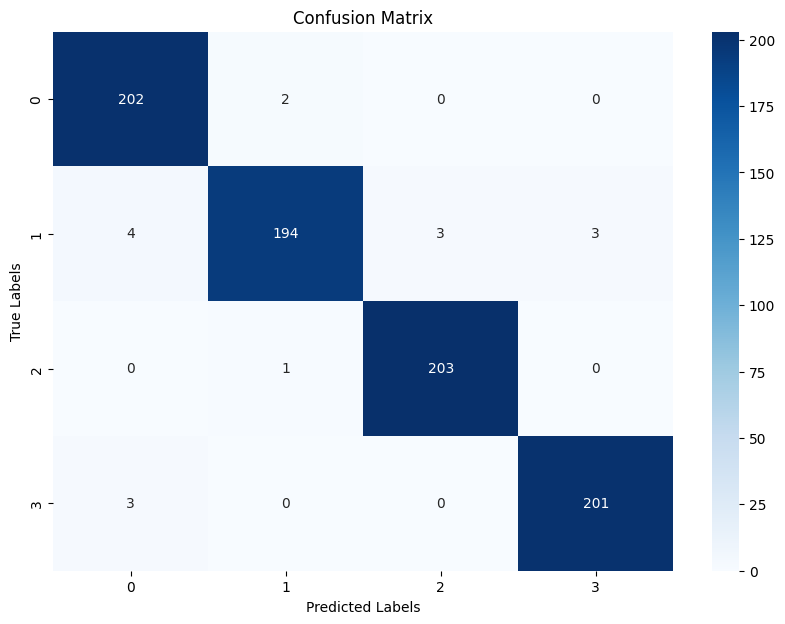

In [ ]:
!pip install matplotlib seaborn


import matplotlib.pyplot as plt
import seaborn as sns


# Confusion Matrix and Metrics
from sklearn.metrics import classification_report, confusion_matrix

cm = confusion_matrix(all_labels, all_preds)

# Printing the confusion matrix
print("Confusion Matrix:")
print(cm)

# Plotting the confusion matrix as a heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


# **Confusion Matrix for four classes**

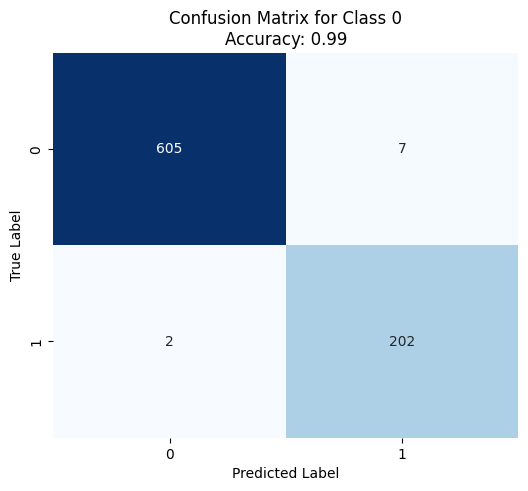

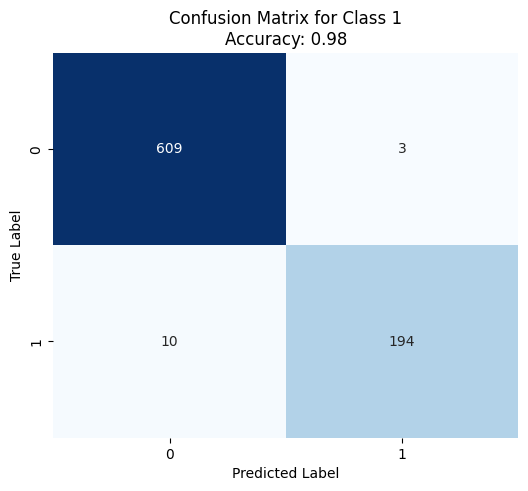

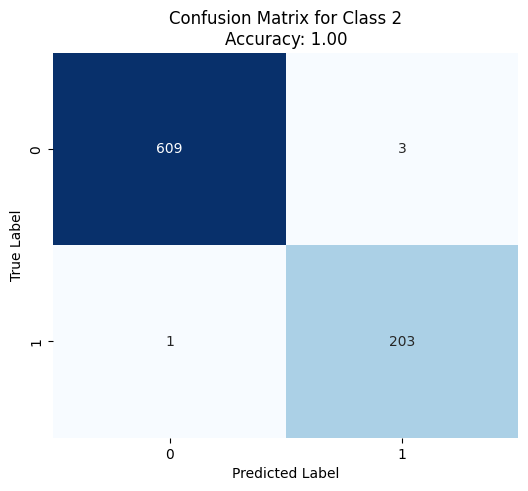

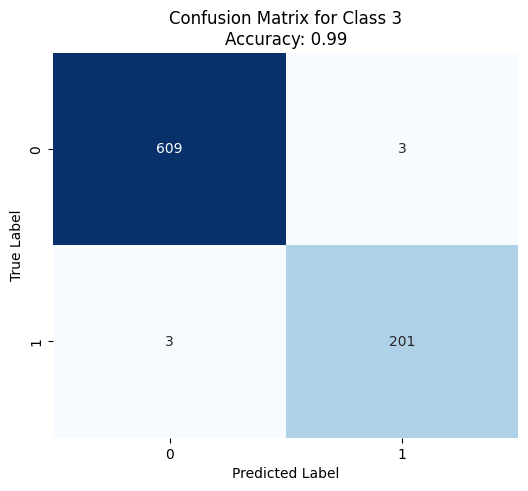

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

import numpy as np


all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

num_classes = 4

for i in range(num_classes):
    # Binarize labels for current class
    binarized_labels = (all_labels == i).astype(int)
    binarized_preds = (all_preds == i).astype(int)

    # Compute confusion matrix
    cm = confusion_matrix(binarized_labels, binarized_preds)

    # Calculate accuracy
    accuracy = (cm[0, 0] + cm[1, 1]) / cm.sum()

    # Plot confusion matrix
    plot_confusion_matrix(cm, class_name=str(i), accuracy=accuracy)



# **ROC-AUC**

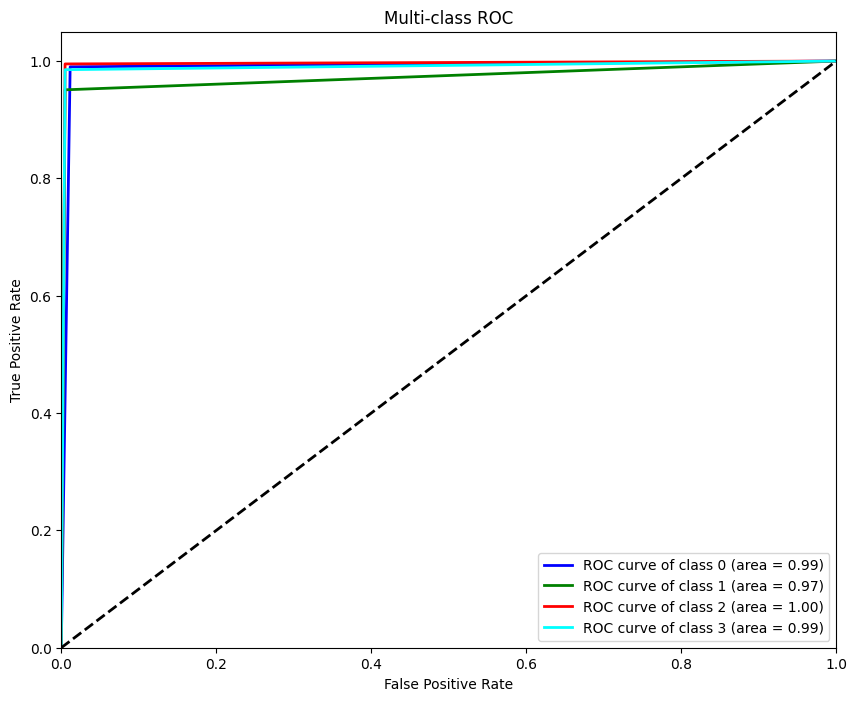

In [ ]:
import numpy as np
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn.preprocessing import label_binarize
from keras.utils import to_categorical

# Convert class indices to one-hot encoded format
all_preds_one_hot = to_categorical(all_preds, num_classes=num_classes)

# Binarize labels
all_labels_binarized = label_binarize(all_labels, classes=range(num_classes))

# Proceed with ROC curve calculation
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(all_labels_binarized[:, i], all_preds_one_hot[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plotting
plt.figure(figsize=(10, 8))
lw = 2  # Line width
colors = cycle(['blue', 'green', 'red', 'cyan', 'magenta', 'yellow', 'black', 'pink', 'lightgreen', 'lightblue'])
for i, color in zip(range(num_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class ROC')
plt.legend(loc="lower right")
plt.show()
